## Sediment Load Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# import SSC continuous record
SSC_spring = pd.read_csv('../../data/SSC/turb_SS_spring.csv', parse_dates=True , index_col='Date_Time') # in mg/L
SSC_summer = pd.read_csv('../../data/SSC/turb_SS_summer.csv', parse_dates=True , index_col='Date_Time') # in mg/L
# drop the Sample column, we will merge later
SSC_spring.drop(columns=['Sample SSC'], inplace=True)
SSC_summer.drop(columns=['Sample SSC'], inplace=True)
# import SSC sample record
SSC_spring_sample = pd.read_csv('../../data/SSC/samples_spring_SSC.csv', parse_dates=True, index_col='Date_Time') # in mg/L
SSC_summer_sample = pd.read_csv('../../data/SSC/samples_summer_SSC.csv', parse_dates=True, index_col='Date_Time') # in mg/L
# import discharge continuous record
discharge = pd.read_csv('../../data/discharge/discharge_2023.csv', parse_dates=True, index_col='Date_Time')

In [2]:
# functions 
def evaluate_prediction(data, measured, predicted):
    """
    evaluate prediction performance using r2 and rmse
    """
    # remove nan values using dropna
    clean_data = data[[measured, predicted]].dropna()
    if clean_data.empty:
        raise ValueError('no valid data available for regression')
    
    true = clean_data[measured].values
    pred = clean_data[predicted].values

    # calculate metrics
    r2 = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    
    return r2, rmse

Merge discharge to SSC 

In [3]:
# resample and interpolate to 1 min intervals
SSC_spring = SSC_spring.resample('1T').mean().interpolate(method='linear')
SSC_summer = SSC_summer.resample('1T').mean().interpolate(method='linear')
discharge = discharge.resample('1T').mean().interpolate(method='linear')

# merge discharge to SSC by date (index)
SSC_spring = SSC_spring.merge(discharge, left_index=True, right_index=True, how='left') 
SSC_summer = SSC_summer.merge(discharge, left_index=True, right_index=True, how='left')
# merge discharge to SSC sample by date (index)
SSC_spring_sample = SSC_spring_sample.merge(discharge, left_index=True, right_index=True, how='left')
SSC_summer_sample = SSC_summer_sample.merge(discharge, left_index=True, right_index=True, how='left')

Calculate Qs (Sediment Load in grams/seconds)

In [4]:
# for continuos records, calculate Qs (Sediment Load in g/s)
SSC_spring['Qs'] = SSC_spring['SSC (mg/L)'] * SSC_spring['Q'] # mg/L * m^3/s = g/s, assuming 1m3 = 1000L and 1g = 1000mg
SSC_summer['Qs'] = SSC_summer['SSC (mg/L)'] * SSC_summer['Q']  
# for sample records, calculate Qs (Sediment Load in g/s)
SSC_spring_sample['Qs'] = SSC_spring_sample['SSC'] * SSC_spring_sample['Q'] 
SSC_summer_sample['Qs'] = SSC_summer_sample['SSC'] * SSC_summer_sample['Q'] 

### Plots

Calculated SS load (turbidity record) vs observed SS load (samples)

In [5]:
# merge continuous to sample record
SSC_spring_sample = SSC_spring_sample.merge(SSC_spring['Qs'], left_index=True, right_index=True, how='left', suffixes=('', '_turb'))
SSC_summer_sample = SSC_summer_sample.merge(SSC_summer['Qs'], left_index=True, right_index=True, how='left', suffixes=('', '_turb'))

# compute metrics for each season
r2_spring, rmse_spring = evaluate_prediction(SSC_spring_sample, 'Qs', 'Qs_turb')
r2_summer, rmse_summer = evaluate_prediction(SSC_summer_sample, 'Qs', 'Qs_turb')

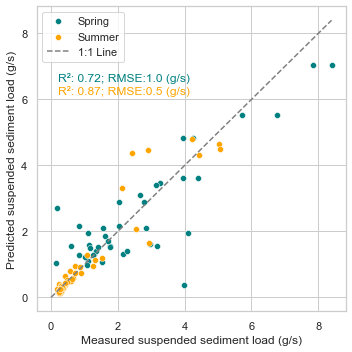

In [6]:
# scatter plot of continuous vs sample records
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.scatterplot(data=SSC_spring_sample, x='Qs', y='Qs_turb', label='Spring', color='teal')
sns.scatterplot(data=SSC_summer_sample, x='Qs', y='Qs_turb', label='Summer', color='orange')
# plot 1:1 line
plt.plot([0, SSC_spring_sample['Qs'].max()], [0, SSC_spring_sample['Qs'].max()], color='gray', linestyle='--', label='1:1 Line')
# add r2 and RMSE to the plot
plt.text(0.2, 6.5, f'R²: {r2_spring:.2f}; RMSE:{rmse_spring:.1f} (g/s)', fontsize=12, verticalalignment='bottom', color='teal')
plt.text(0.2, 6.1, f'R²: {r2_summer:.2f}; RMSE:{rmse_summer:.1f} (g/s)', fontsize=12, verticalalignment='bottom', color='orange')
plt.xlabel('Measured suspended sediment load (g/s)')
plt.ylabel('Predicted suspended sediment load (g/s)')
plt.legend()
plt.tight_layout()
plt.show()


Time Series

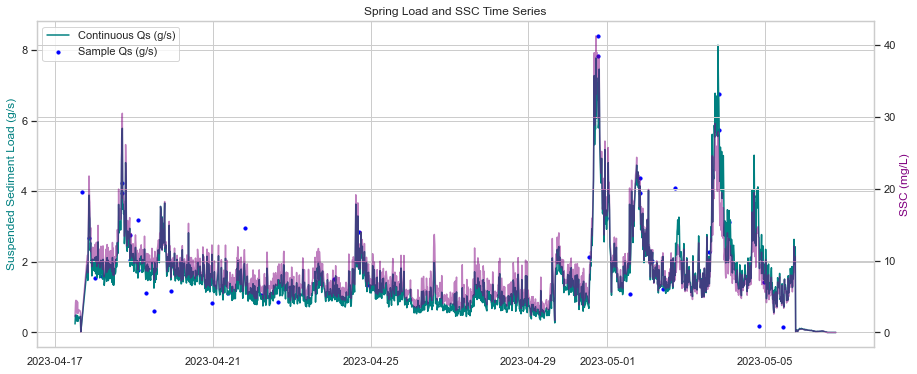

In [7]:
# plot time series of spring continuous record
plt.figure(figsize=(15, 6))
plt.plot(SSC_spring.index, SSC_spring['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(SSC_spring_sample.index, SSC_spring_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(SSC_spring.index, SSC_spring['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.5)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Spring Load and SSC Time Series')
plt.show()

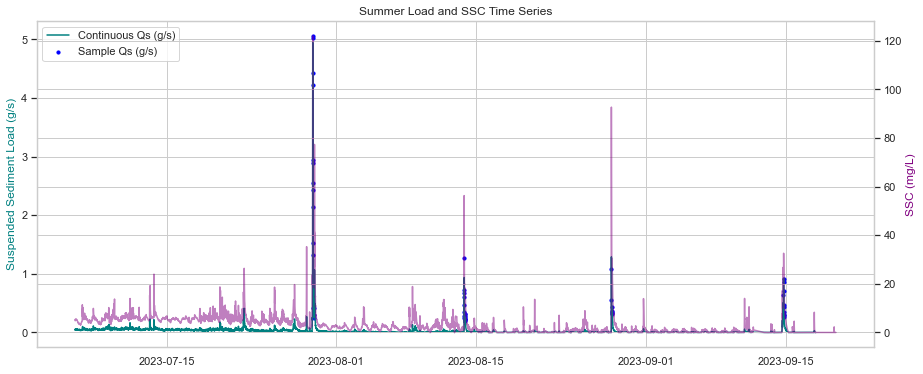

In [8]:
# plot time series of spring continuous record
plt.figure(figsize=(15, 6))
plt.plot(SSC_summer.index, SSC_summer['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(SSC_summer_sample.index, SSC_summer_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(SSC_summer.index, SSC_summer['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.5)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Summer Load and SSC Time Series')
plt.show()

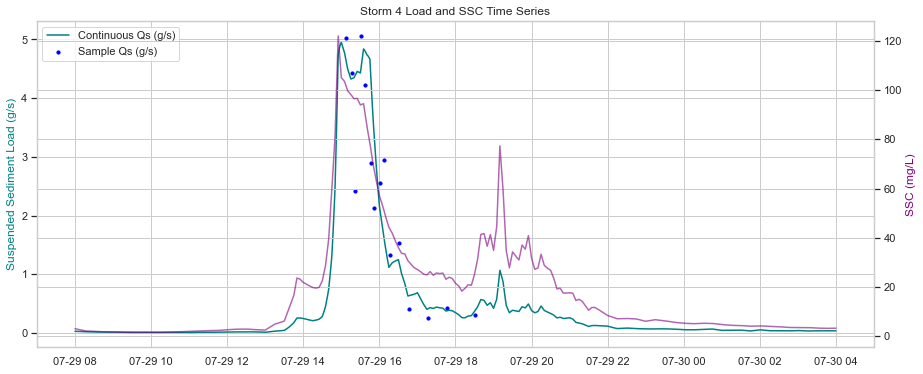

In [9]:
# Storm 4: 
# 07/29/23 to 08/01/23
storm_start = '2023-07-29 08:00:00'
storm_end = '2023-07-30 04:00:00'
# filter storm data
storm4 = SSC_summer.loc[storm_start:storm_end] 
storm4_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm4.index, storm4['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm4_sample.index, storm4_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm4.index, storm4['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 4 Load and SSC Time Series')
plt.show()


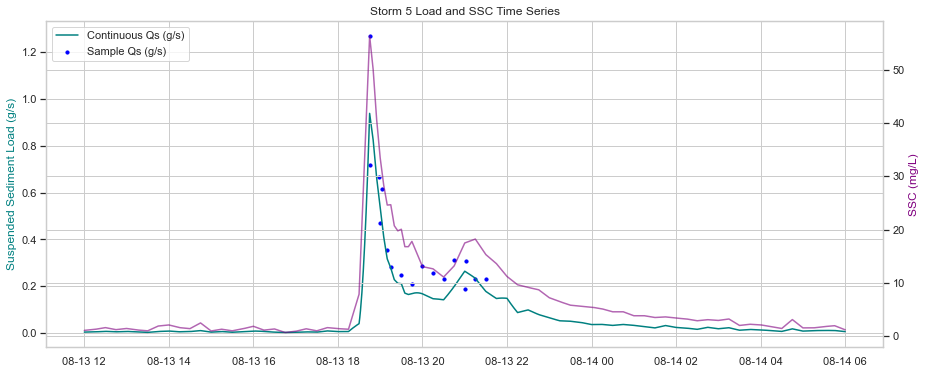

In [10]:
# Storm 5: 
# 08/13/23 to 08/14/23
storm_start = '2023-08-13 12:00:00'
storm_end = '2023-08-14 06:00:00'
# filter storm data
storm5 = SSC_summer.loc[storm_start:storm_end] 
storm5_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm5.index, storm5['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm5_sample.index, storm5_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm5.index, storm5['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 5 Load and SSC Time Series')
plt.show()

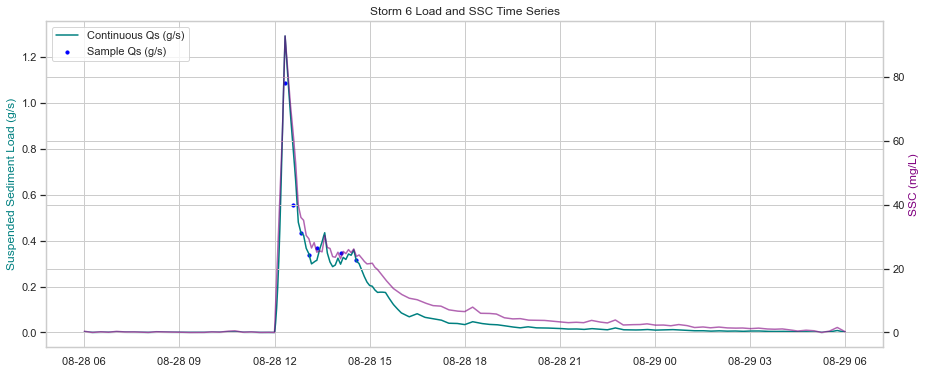

In [11]:
# Storm 6: 
# 08/28/23 to 08/29/23
storm_start = '2023-08-28 06:00:00'
storm_end = '2023-08-29 06:00:00'
# filter storm data
storm6 = SSC_summer.loc[storm_start:storm_end] 
storm6_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm6.index, storm6['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm6_sample.index, storm6_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm6.index, storm6['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 6 Load and SSC Time Series')
plt.show()

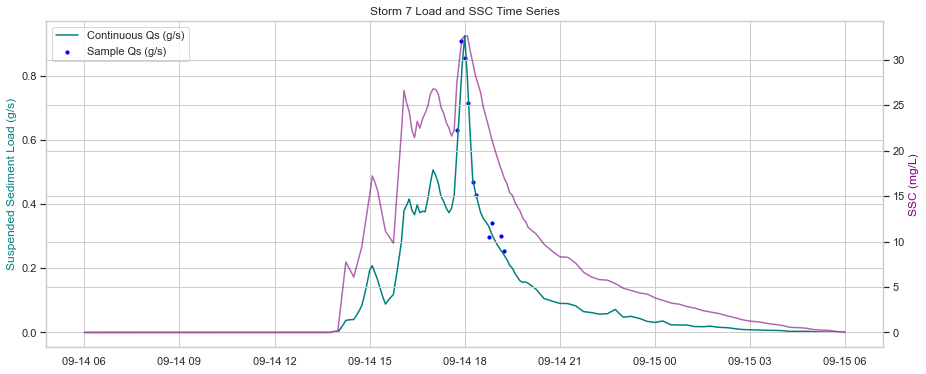

In [12]:
# Storm 7: 
# 09/14/23 to 09/15/23
storm_start = '2023-09-14 06:00:00'
storm_end = '2023-09-15 06:00:00'
# filter storm data
storm7 = SSC_summer.loc[storm_start:storm_end] 
storm7_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm7.index, storm7['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm7_sample.index, storm7_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm7.index, storm7['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 7 Load and SSC Time Series')
plt.show()

### Export to csv

In [ ]:
# delete all columns except for SSC, Q and Qs
SSC_spring_sample = SSC_spring_sample[['Sample ', 'SSC', 'Q', 'Qs']]
SSC_summer_sample = SSC_summer_sample[['Sample ', 'SSC', 'Q', 'Qs']]

# save the data
SSC_spring.to_csv('suspended_sediment_load/Qs_spring_continuous.csv')
SSC_summer.to_csv('suspended_sediment_load/Qs_summer_continuous.csv')
SSC_spring_sample.to_csv('suspended_sediment_load/Qs_spring_sample.csv')
SSC_summer_sample.to_csv('suspended_sediment_load/Qs_summer_sample.csv')